# Setup

In [1]:
from _ctypes import LoadLibrary as _dlopen
_dlopen("D:\\Sangwons_Room\\00_SoftWares\\Anaconda\\envs\\torch\\Library\\bin\\geos.dll", 0)

140715744100352

In [2]:

# nuscenes-devkit
from nuscenes.nuscenes import NuScenes

# nuscenes-map expansion
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap

# nuscenes-devkit-utils
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.geometry_utils import view_points, transform_matrix

# nuscenes-custom-utils
from utils.custom_lidar_api import CustomLidarApi

from pyquaternion import Quaternion


from functools import reduce
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import tqdm
%matplotlib inline

KeyboardInterrupt: 

In [ ]:
nusc = NuScenes(version='v1.0-mini', dataroot='./data/sets/nuscenes', verbose=True)



# Get One Sample

In [ ]:
nusc.list_scenes()

In [ ]:
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_scene

In [ ]:
my_sample = nusc.get('sample', first_sample_token)
my_sample

In [ ]:
lidar_top_data = nusc.get('sample_data', my_sample['data']['LIDAR_TOP'])
pcl_path = os.path.join(nusc.dataroot, lidar_top_data['filename'])

pc = LidarPointCloud.from_file(pcl_path)
print(pc.points.shape)

In [ ]:
fig = px.scatter_3d(x = pc.points[0,:], y = pc.points[1,:], z = pc.points[2,:], size = np.ones_like(pc.points[0,:]) * 0.3, 
                    size_max = 2, range_x = [-100, 100], range_y = [-100, 100], range_z = [-100, 100],
                   width = 800, height = 500)

fig.show()

In [ ]:
lidar_top_data

# Scene

In [ ]:
my_sample['data']['LIDAR_TOP']

In [ ]:
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
last_sample_token = my_scene['last_sample_token']

token = first_sample_token
count = 0
while(token != last_sample_token):
    my_sample = nusc.get('sample', token)
    
    lidar_top_data = nusc.get('sample_data', my_sample['data']['LIDAR_TOP'])
    pcl_path = os.path.join(nusc.dataroot, lidar_top_data['filename'])

    pc = LidarPointCloud.from_file(pcl_path)
    print(pc.points.shape)

    token = my_sample['next']
    count+=1
    print(count, token)


In [ ]:
lidar_top_data

In [ ]:
pc_file, d, d2 = nusc.get_sample_data(lidar_top_data['token'])
d[0]

In [ ]:
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
last_sample_token = my_scene['last_sample_token']

token = first_sample_token
count = 0
while(token != last_sample_token):
    my_sample = nusc.get('sample', token)
    
    lidar_top_data = nusc.get('sample_data', my_sample['data']['LIDAR_TOP'])
    pcl_path = os.path.join(nusc.dataroot, lidar_top_data['filename'])

    pc = LidarPointCloud.from_file(pcl_path)
    print(pc.points.shape)

    token = my_sample['next']
    count+=1
    print(count, token)


In [ ]:
sample = nusc.sample[0]
pcl, _ = LidarPointCloud.from_file_multisweep(nusc, sample, 'LIDAR_TOP', 'LIDAR_TOP', nsweeps=10)
print(pcl.points.T.dtype)

In [ ]:
lidar_top_data

In [ ]:
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
last_sample_token = my_scene['last_sample_token']

sample_rec = nusc.get('sample', last_sample_token)
last_time = sample_rec['timestamp']

sample_rec = nusc.get('sample', first_sample_token)
first_time = sample_rec['timestamp']

ref_sd_token = sample_rec['data']['LIDAR_TOP']
ref_sd_rec = nusc.get('sample_data', ref_sd_token)
ref_pose_rec = nusc.get('ego_pose', ref_sd_rec['ego_pose_token'])
ref_cs_rec = nusc.get('calibrated_sensor', ref_sd_rec['calibrated_sensor_token'])
ref_time = 1e-6 * ref_sd_rec['timestamp']

# Homogeneous transform from ego car frame to reference frame.
ref_from_car = transform_matrix(ref_cs_rec['translation'], Quaternion(ref_cs_rec['rotation']), inverse=True)

# Homogeneous transformation matrix from global to _current_ ego car frame.
car_from_global = transform_matrix(ref_pose_rec['translation'], Quaternion(ref_pose_rec['rotation']),
                                   inverse=True)

sample_data_token = sample_rec['data']['LIDAR_TOP']
current_sd_rec = nusc.get('sample_data', sample_data_token)

print(last_time - first_time)
for i in range(1000):
    print(f"{i} : {current_sd_rec['timestamp'] - first_time}")
    current_pc = LidarPointCloud.from_file(os.path.join(nusc.dataroot, current_sd_rec['filename']))

    current_pose_rec = nusc.get("ego_pose", current_sd_rec['ego_pose_token'])
    global_from_car = transform_matrix(current_pose_rec['translation'], Quaternion(current_pose_rec['rotation']), inverse = False)

    current_cs_rec = nusc.get('calibrated_sensor', current_sd_rec['calibrated_sensor_token'])
    car_from_current = transform_matrix(current_cs_rec['translation'], Quaternion(current_cs_rec['rotation']), inverse =False)

    trans_matrix = reduce(np.dot, [ref_from_car, car_from_global, global_from_car, car_from_current])
    current_pc.transform(trans_matrix)

    if current_sd_rec['next'] == "":
        break
    else:
        current_sd_rec = nusc.get('sample_data', current_sd_rec['next'])

# Map

In [ ]:
nusc_map = NuScenesMap(dataroot='./data/sets/nuscenes', map_name='singapore-onenorth')

In [ ]:
print(nusc_map.non_geometric_line_layers)
print(nusc_map.non_geometric_polygon_layers)

In [ ]:
token = records_within_patch['road_block'][0]

record = nusc_map.get('road_block', token)

exterior_nodes = [nusc_map.get('node', token) for token in record['exterior_node_tokens']]
exterior_node_coords = np.array([(node['x'], node['y']) for node in exterior_nodes])
exterior_node_coords

In [ ]:
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
last_sample_token = my_scene['last_sample_token']

sample_rec = nusc.get('sample', last_sample_token)
last_time = sample_rec['timestamp']

sample_rec = nusc.get('sample', first_sample_token)
first_time = sample_rec['timestamp']

ref_sd_token = sample_rec['data']['LIDAR_TOP']
ref_sd_rec = nusc.get('sample_data', ref_sd_token)
ref_pose_rec = nusc.get('ego_pose', ref_sd_rec['ego_pose_token'])
ref_cs_rec = nusc.get('calibrated_sensor', ref_sd_rec['calibrated_sensor_token'])
ref_time = 1e-6 * ref_sd_rec['timestamp']

# Homogeneous transform from ego car frame to reference frame.
ref_from_car = transform_matrix(ref_cs_rec['translation'], Quaternion(ref_cs_rec['rotation']), inverse=True)

# Homogeneous transformation matrix from global to _current_ ego car frame.
car_from_global = transform_matrix(ref_pose_rec['translation'], Quaternion(ref_pose_rec['rotation']),
                                   inverse=True)

sample_data_token = sample_rec['data']['LIDAR_TOP']
current_sd_rec = nusc.get('sample_data', sample_data_token)

print(last_time - first_time)
for i in range(1000):
    print(f"{i} : {current_sd_rec['timestamp'] - first_time}")
    current_pc = LidarPointCloud.from_file(os.path.join(nusc.dataroot, current_sd_rec['filename']))

    current_pose_rec = nusc.get("ego_pose", current_sd_rec['ego_pose_token'])
    global_from_car = transform_matrix(current_pose_rec['translation'], Quaternion(current_pose_rec['rotation']), inverse = False)
    
    my_patch = (current_pose_rec['translation'][0] - 500, current_pose_rec['translation'][1] - 500, 1000, 1000)
    records_within_patch = nusc_map.get_records_in_patch(my_patch, nusc_map.non_geometric_layers, mode='within')
    
    traffic_lights = []
    for record in records_within_patch['traffic_light']:
        traffic_lights.append(nusc_map.get_bounds('traffic_light', record))
        
    road_blocks = []
    for record in records_within_patch['road_block']:
        road_blocks.append(nusc_map.get_bounds('road_block', record))
        
    print(traffic_lights)
    if current_sd_rec['next'] == "":
        break
    else:
        current_sd_rec = nusc.get('sample_data', current_sd_rec['next'])

In [ ]:
def get_layers_bound_in_patch(nusc_map, patch, layers):
    out_ = dict()
    
    token = records_within_patch['road_block'][0]

    for layer in layers:
        if layer in nusc_map.non_geometric_polygon_layers:
            tokens = patch[layer]
            layer_coords = []
            for token in tokens:
                record = nusc_map.get(layer, token)
                nodes = [nusc_map.get('node', token) for token in record['exterior_node_tokens']]
                node_coords = np.array([(node['x'], node['y']) for node in nodes])
                layer_coords.append(node_coords.reshape(1, -1, 2))
            out_[layer] = np.concatenate(node_coords, axis = 0)
        elif layer in nusc_map.non_geometric_line_layers:
            pass
            
        
    
    return out_
    
bounds = get_layers_bound_in_patch(nusc_map, records_within_patch, ['traffic_light', 'road_block', 'walkway', 'lane_divider'])

In [ ]:
bounds['road_block'].shape

# Lidar Visualization

In [ ]:
%clear

In [ ]:

# nuscenes-devkit
from nuscenes.nuscenes import NuScenes
from utils.custom_lidar_api import CustomLidarApi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import tqdm


nusc = NuScenes(version='v1.0-mini', dataroot='./data/sets/nuscenes', verbose=False)
ldr_api = CustomLidarApi(nusc)

my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
last_sample_token = my_scene['last_sample_token']

token = first_sample_token

my_sample = nusc.get('sample', token)
first_time_1e6 = my_sample['timestamp']

count = 0
pc_list = []
while (token != last_sample_token):
    print(count)
    my_sample = nusc.get('sample', token)
    current_time_1e6 = my_sample['timestamp']
    time = (current_time_1e6 - first_time_1e6) * 1e-6

    pc = ldr_api.get_lidar_from_keyframe(token)
    index = np.random.choice(pc.points.shape[1], int(pc.points.shape[1] * 0.01)).astype(int)
    points = pc.points.T[index, :]
    temp = pd.DataFrame(points, columns = ['x','y','z','intensity'])
    temp['time'] = time
    pc_list.append(temp)

    token = my_sample['next']
    count += 1

df = pd.concat(pc_list, axis = 0)
df['dummy'] = 10

In [ ]:
px.scatter(df, x="x", y="y", animation_frame="time",
           size_max=10, range_x=[-100,100], range_y=[-100,100])

# Nuscene One Frame Visualization

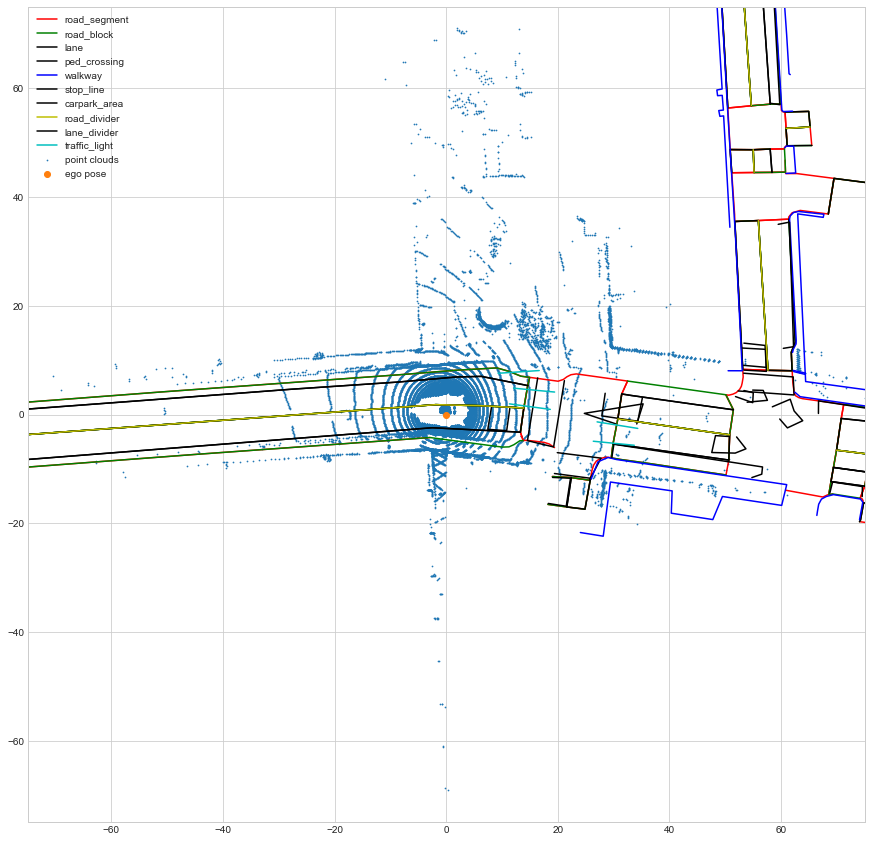

In [33]:
from nuscenes.nuscenes import NuScenes
from utils.custom_lidar_api import CustomLidarApi
from utils.custom_map_api_expansion import CustomNuScenesMap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import tqdm

# params
locations = ['singapore-onenorth', 'singapore-hollandvillage', 'singapore-queenstown', 'boston-seaport']
version = 'v1.0-mini'
dataroot = './data/sets/nuscenes'
target_layer = [
    'drivable_area',
    'road_segment',
    'road_block',
    'lane',
    'ped_crossing',
    'walkway',
    'stop_line',
    'carpark_area',
    'road_divider',
    'lane_divider',
    'traffic_light'
]

layer_color = {
    'drivable_area':'k',
    'road_segment':'r',
    'road_block':'g',
    'lane':'k',
    'ped_crossing':'k',
    'walkway':'b',
    'stop_line':'k',
    'carpark_area':'k',
    'road_divider':'y',
    'lane_divider':'k',
    'traffic_light':'c'
        }
layer_count = {
    'drivable_area':0,
    'road_segment':0,
    'road_block':0,
    'lane':0,
    'ped_crossing':0,
    'walkway':0,
    'stop_line':0,
    'carpark_area':0,
    'road_divider':0,
    'lane_divider':0,
    'traffic_light':0,
}

# load apis
nusc = NuScenes(version=version, dataroot=dataroot, verbose=False)
ldr_api = CustomLidarApi(nusc)

map_api = dict([])
for location in locations:
    map_api[location] = CustomNuScenesMap(dataroot = dataroot, map_name= location)

# get one sample
scene = nusc.scene[1]
token = scene['first_sample_token']
log_meta = nusc.get('log', scene['log_token'])

sample = nusc.get('sample', token)
sample = nusc.get('sample', sample['next'])
sample = nusc.get('sample', sample['next'])
sample = nusc.get('sample', sample['next'])


sample_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
token = sample['token']

pc = ldr_api.get_lidar_from_keyframe(token, car_coord = True)
ego = ldr_api.get_egopose_from_keyframe(token)
cs = nusc.get('calibrated_sensor', sample_data['calibrated_sensor_token'])
structures = map_api[log_meta['location']].get_closest_structures(target_layer, ego, global_coord=False, max_objs=2048, max_points=1024, patch=[300, 300], mode = 'intersect')

fig, axes = plt.subplots(1, 1, figsize = (15, 15))
ax = axes
ax.scatter(-pc.points[0,:], -pc.points[1,:], s = 0.5, label = 'point clouds')
ax.scatter(0,0, label = 'ego pose')
for structure in structures:
    layer_count[structure['class']] += 1
    non_zeros = (structure['nodes'][:,0] != 0) &(structure['nodes'][:,1] != 0)
    if layer_count[structure['class']] > 1:
        ax.plot(structure['nodes'][non_zeros, 0], structure['nodes'][non_zeros, 1], color = layer_color[structure['class']])
    else:
        ax.plot(structure['nodes'][non_zeros, 0], structure['nodes'][non_zeros, 1], color = layer_color[structure['class']], label = structure['class'])
        
plt.legend()
plt.xlim([-75, 75])
plt.ylim([-75, 75])
plt.savefig('vis_map2.jpg')


In [12]:
map_api['singapore-onenorth'].non_geometric_layers

['drivable_area',
 'road_segment',
 'road_block',
 'lane',
 'ped_crossing',
 'walkway',
 'stop_line',
 'carpark_area',
 'road_divider',
 'lane_divider',
 'traffic_light']

# Scene Ego Trajectory

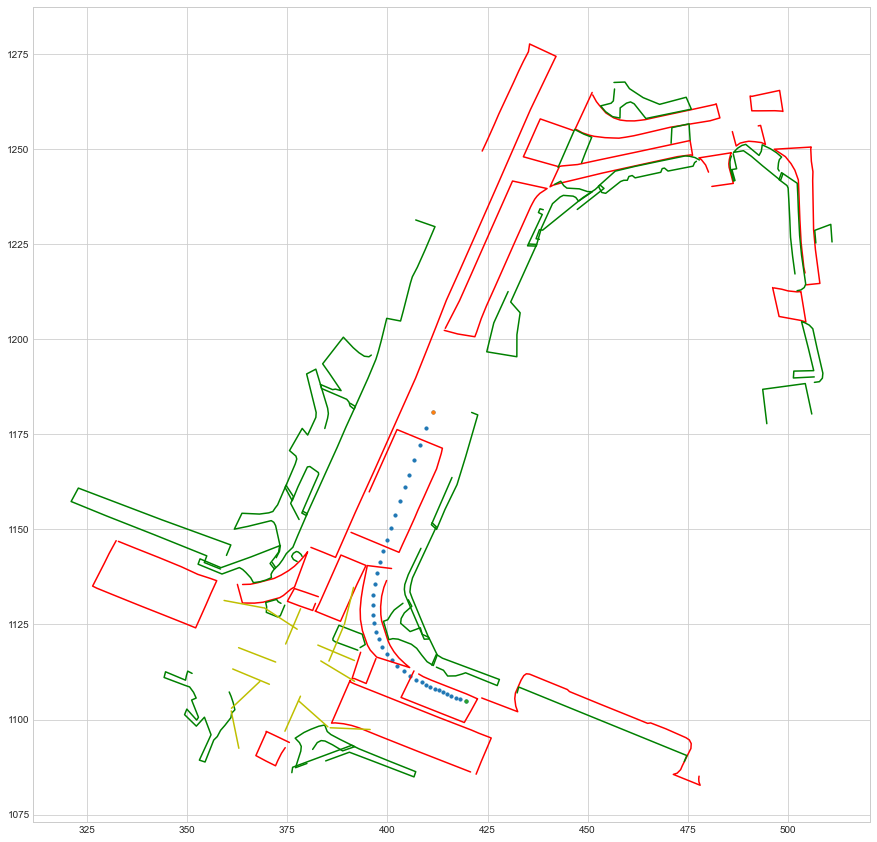

In [5]:
from nuscenes.nuscenes import NuScenes
from utils.custom_lidar_api import CustomLidarApi
from utils.custom_map_api_expansion import CustomNuScenesMap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import tqdm

# params
locations = ['singapore-onenorth', 'singapore-hollandvillage', 'singapore-queenstown', 'boston-seaport']
version = 'v1.0-mini'
dataroot = './data/sets/nuscenes'
target_layer = [ 'road_block', 'walkway', 'road_divider', 'traffic_light']

# load apis
nusc = NuScenes(version=version, dataroot=dataroot, verbose=False)
ldr_api = CustomLidarApi(nusc)

map_api = dict([])
for location in locations:
    map_api[location] = CustomNuScenesMap(dataroot = dataroot, map_name= location)

scene = nusc.scene[0]
token = scene['first_sample_token']
log_meta = nusc.get('log', scene['log_token'])

sample = nusc.get('sample', token)
pc = ldr_api.get_lidar_from_keyframe(token)
ego = ldr_api.get_egopose_from_keyframe(token)
structures_global = map_api[log_meta['location']].get_closest_structures(target_layer, ego, global_coord=True)

poses = []
while token != scene['last_sample_token']:
    sample = nusc.get('sample', token)
    pc = ldr_api.get_lidar_from_keyframe(token)
    ego = ldr_api.get_egopose_from_keyframe(token)
    poses.append(np.array(ego['translation']).reshape(1,3))
    
    token = sample['next']
    
poses = np.concatenate(poses, axis = 0)

fig = plt.figure(figsize = (15, 15))
ax = plt.gca()
ax.scatter(poses[:,0], poses[:,1], s = 10)
ax.scatter(poses[0,0], poses[0,1], s = 10)
ax.scatter(poses[-1,0], poses[-1,1], s = 10)
for structure in structures_global:
    layer_count[structure['class']] += 1
    non_zeros = (structure['nodes'][:,0] != 0) &(structure['nodes'][:,1] != 0)
    if layer_count[structure['class']] > 1:
        ax.plot(structure['nodes'][non_zeros, 0], structure['nodes'][non_zeros, 1], color = layer_color[structure['class']])
    else:
        ax.plot(structure['nodes'][non_zeros, 0], structure['nodes'][non_zeros, 1], color = layer_color[structure['class']], label = structure['class'])
    
    
plt.show()

